# Case study: Reinforcement Learning
### We use RatInABox to train a model-free RL agent to find a reward hidden behind a wall.

In [1]:
#Import ratinabox
sys.path.append('../')
from ratinabox import *

from tqdm import tqdm

## Policy Evaluation

There are two key components to most model-free RL algorithms. Policy evaluation evaluates a policy and establishes its "value function". Policy improvement uses this value estimate to make a better policy. Iterating between these two often results in convergence towards a near-optimal policy. 

To help with these process we define a `ValueNeuron`. The `ValueNeuron`, which is a subclass of `FeedForwardLayer` (which is a subclass of `Neurons`) recieves feedforward input from a set of  input features (these will be `PlaceCells` scattered across the `Environment`) $\{\mathsf{I}_{i}\}_{i=1}^{N}$. The firing rate of the `ValueNeuron` is given as a weighted linear sum of its inputs:

$$ \mathsf{\hat{V}}(\mathsf{I}(t);\mathsf{w}) = \sum_{i=1}^{N}\mathsf{w}_{i}\mathsf{I}_{i}(t).$$

The goal is to adjust the weights, $\mathsf{w}_{i}$ such that  $\mathsf{\hat{V}}(t)$ approximates the "value" of the current policy. The value of the current policy $\pi$ is defined as the decaying sum of expected future rewards 

$$\mathsf{\hat{V}}(t) \approx \mathsf{V}^{\pi}(t) = \mathbb{E} \bigg[  \frac{1}{\tau} \int_{t}^{\infty} e^{-\frac{t^{\prime}-t}{\tau}} \mathsf{R}(t^{\prime}) dt^{\prime}\bigg] $$

where here the expectation is taken over any stochasticity present in the current policy (i.e. how the `Agent` moves) and `Environement` (in this case the environment will be deterministic). This definition of value is temporally continuous: the key differences compared to the more common form where value is written as a sum of rewards over discrete future timesteps, is that it is now a continuous integral over a reward *density* function and temporal discounting is done by the exponential decaying over a time period $\tau$. The prefactor of $1/\tau$ is an optional constant of normalisation. 

We can take the temporal derivative of this and derive a consistency equation (analagous to the Bellman equation) satisfied by this value function. This naturally gives a temporal difference-style update rule which relies on "bootstrapping" (the current estimate of the value function is used in lieu of the true value function) to optimize the weights of the value function approximation. A good reference for continuous RL is Doya (2000) if you want to know more about deriving this learning rule.

$$ \delta \mathsf{w_i}(t) = \eta \bigg( \mathsf{R}(t) + \tau \frac{d\mathsf{\hat{V}}(t)}{dt} - \mathsf{\hat{V}(t)} \bigg) \mathsf{e}_i(t) $$

For now however it suffices to observe that this learning rule is very similar to the temporally discrete TD-update rule. The first term represents the continuous analog of the temporal difference error (in fact, if you rediscretise with using the euler formula to replace the derivative yoou will see they are identical). The second term is the `eligibility trace' (using an eligibility trace is optional, and it could just be replaced with $\mathsf{I}_i(t)$, however doing so aids stability of the learning) of feature inputs, defined as: 

$$\mathsf{e}_i(t) = \frac{1}{\tau_{\mathsf{e}}} \int_{-\infty}^{t} e^{-\frac{t-t^{\prime}}{\tau_{\mathsf{e}}}} \mathsf{I}_i(t^{\prime}) dt^{\prime}$$

To learn the value function, therefore, the `ValueNeuron` needs to
1. Be able to linearly summate its inputs. Already implemented by `FeedForwardLayer.update()`
2. Store and update the eligibility trace.
3. Implement the learning rule. This will require access to the reward density function $\mathsf{R}(t)$, the eligibiilty traces $\mathsf{e}_i(t)$, the firing rate $\mathsf{\hat{V}}(t)$ and the temporal derivtive of the firing rate $\frac{d\mathsf{\hat{V}}(t)}{dt}$

We will use a temporal discounting timescale of $\tau =$ 10 seconds and an eligibility trace timescale of $\tau_{\mathsf{e}} =$ 5 seconds. Note that the inputs and rewards will both be provided by layers of `RatInABox` "`PlaceCells`". 

In [37]:
class ValueNeuron(FeedForwardLayer):

    def __init__(self, Agent, params={}):
        default_params = {
            "input_layer": None,  # the features it is using as inputs
            "reward_layer": None,  # the layer which is the reward 
            "tau":10, #discount time horizon
            "tau_e":5, #eligibility trace timescale
            "eta":0.0001, #learning rate
        }

        default_params.update(params)
        self.params = default_params
        self.params['activation_params']={'activation':'linear'} #we use linear func approx
        self.params['n']=1 #one value neuron 
        self.params['input_layers'] = [self.params['input_layer']]
        super().__init__(Agent, self.params) #initialise parent class

        self.et = np.zeros(params['input_layer'].n) #initialise eligibility trace
        self.firingrate = np.zeros(1) #initialise firing rate
        self.firingrate_deriv = np.zeros(1) #initialise firing rate derivative


    def update_firingrate(self):
        firingrate_last = self.firingrate #cache
        #update the firing rate
        self.update() #FeedForwardLayer builtin function. this sums the inouts from the input features over the weight matrix and saves the firingrate. 
        #calculate temporal derivative of the firing rate 
        self.firingrate_deriv = (self.firingrate - firingrate_last)/self.Agent.dt
        # update eligibility trace 
        self.et = ((self.Agent.dt/self.tau_e) * self.input_layer.firingrate + 
                   (1 - self.Agent.dt/self.tau_e) * self.et)
        return

    def update_weights(self):
        """Trains the weights by implementing the TD learnign rule"""
        W = self.inputs[self.input_layer.name]['W'] #weights
        R = self.reward_layer.firingrate #current reward
        V = self.firingrate #current value estimate
        dVdt = self.firingrate_deriv #currrent value derivative estimate
        td_error = R + self.tau * dVdt - V
        dW = self.Agent.dt*self.eta*(np.outer(td_error,self.et)) - 0.0001*W #note L2 regularisation
        self.inputs[self.input_layer.name]['W'] += dW
        return
    
    def get_steep_ascent(self,pos):
        """This function will be used for policy improvement. Calculates direction steepest ascent (gradient) of the value function and returns a drift velocity in this direction."""  
        V = self.get_state(evaluate_at=None,pos = pos)[0][0]
        if V < 0.05*self.max_fr: #<--remeber to set max_fr on each training loop
            return None #if the value function is too low it is unreliabe, return None
        else: #calculate gradient locally 
            V_plusdx = self.get_state(evaluate_at=None,pos = pos+np.array([1e-3,0]))[0][0]
            V_plusdy = self.get_state(evaluate_at=None,pos = pos+np.array([0,1e-3]))[0][0]
            gradV = np.array([V_plusdx - V,V_plusdy-V])
            greedy_drift_velocity = 3*self.Agent.speed_mean*gradV / np.linalg.norm(gradV)
    
        return greedy_drift_velocity



We now initialise an `Environment` with a wall. We put an `Agent` inside the environment. 500 `PlaceCells` of random size uniformly distributed across the environment are the input features. A single `PlaceCell` hidden behind the wall is the reward and a `ValueNeuron` (discussed above) will learn the value function. 

In [38]:
Env = Environment()
Env.add_wall([[0.8,0.0],[0.8,0.8]])

Ag = Agent(Env)
Ag.dt = 50e-3 #set discretisation time, large is fine

n_pc = 1000
Inputs = PlaceCells(Ag, params={'n':n_pc,
                                 'widths':np.random.uniform(0.04,0.4,size=(n_pc)),})
Reward = PlaceCells(Ag, params={'n':1,
                                 'place_cell_centres':np.array([[0.9,0.05]]),
                                 'description':'top_hat',
                                 'widths':0.2,
                                 'max_fr':1,})
ValNeur = ValueNeuron(Ag, params={'input_layer':Inputs,'reward_layer':Reward})

Here we display the rate maps of 9 of the input features, the reward neuron and the ValueNeuron (before training with random weight initialisation).

(<Figure size 1200x1200 with 1 Axes>, array([<AxesSubplot:>], dtype=object))

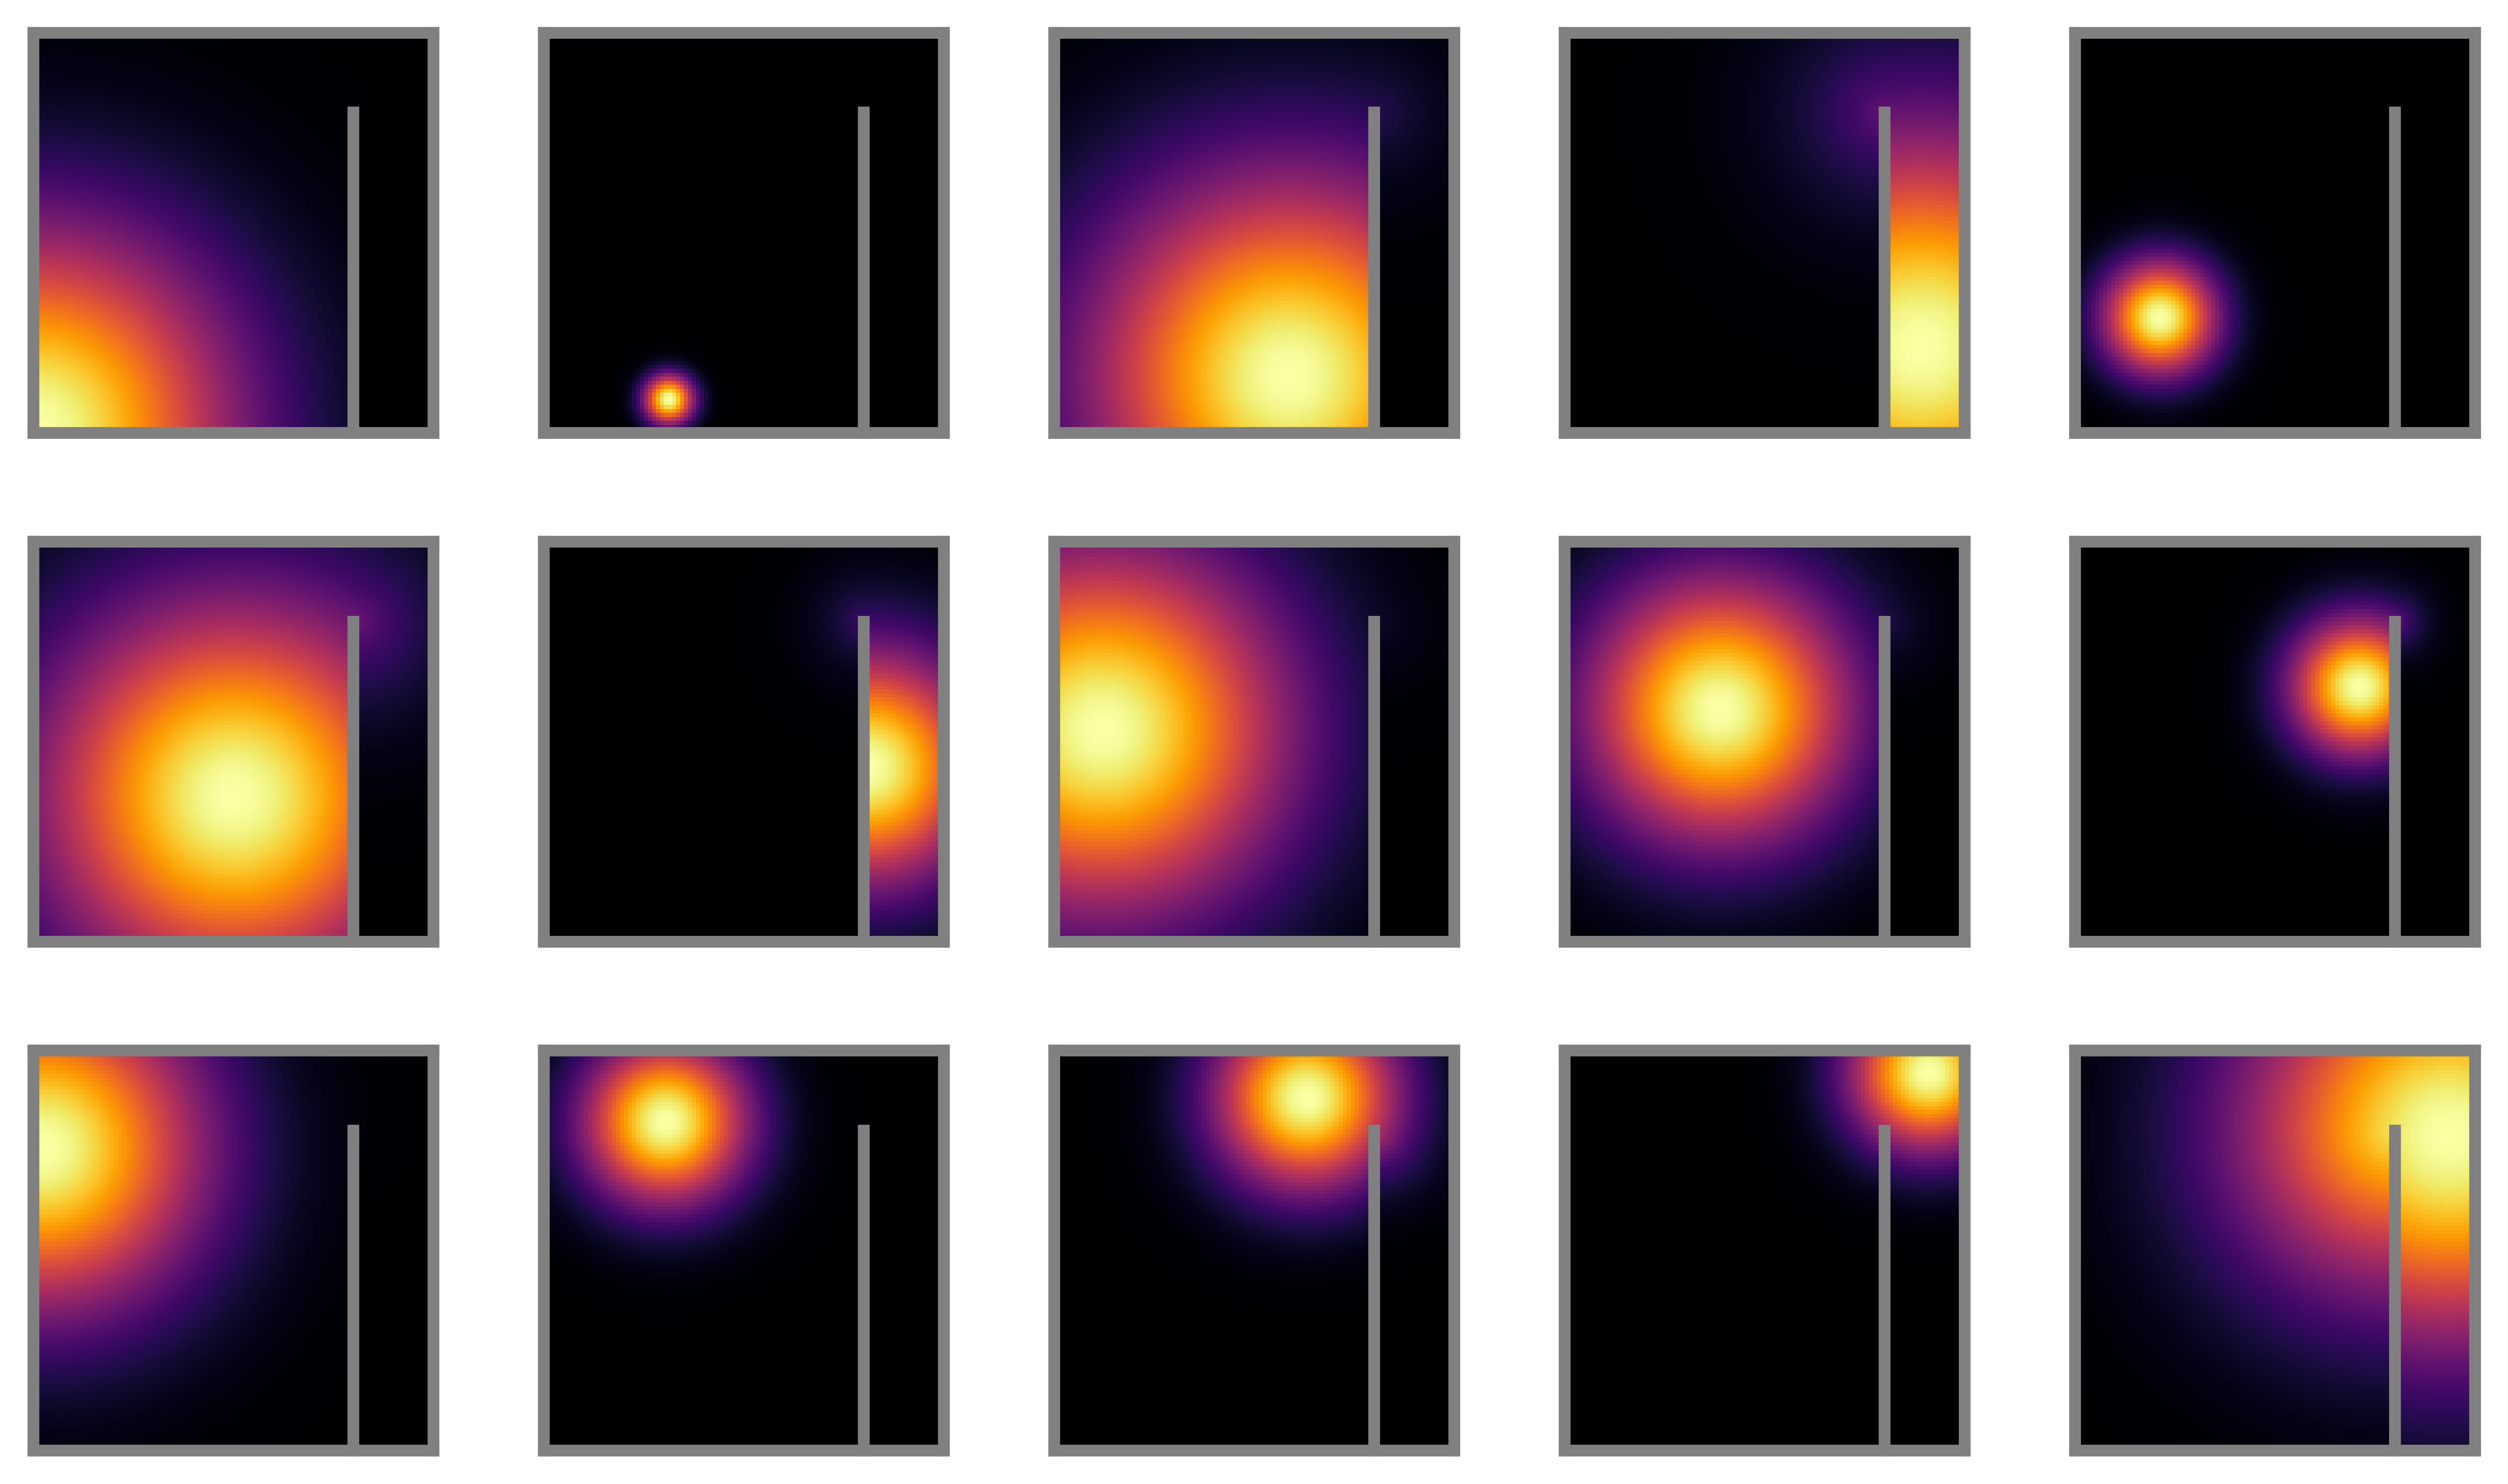

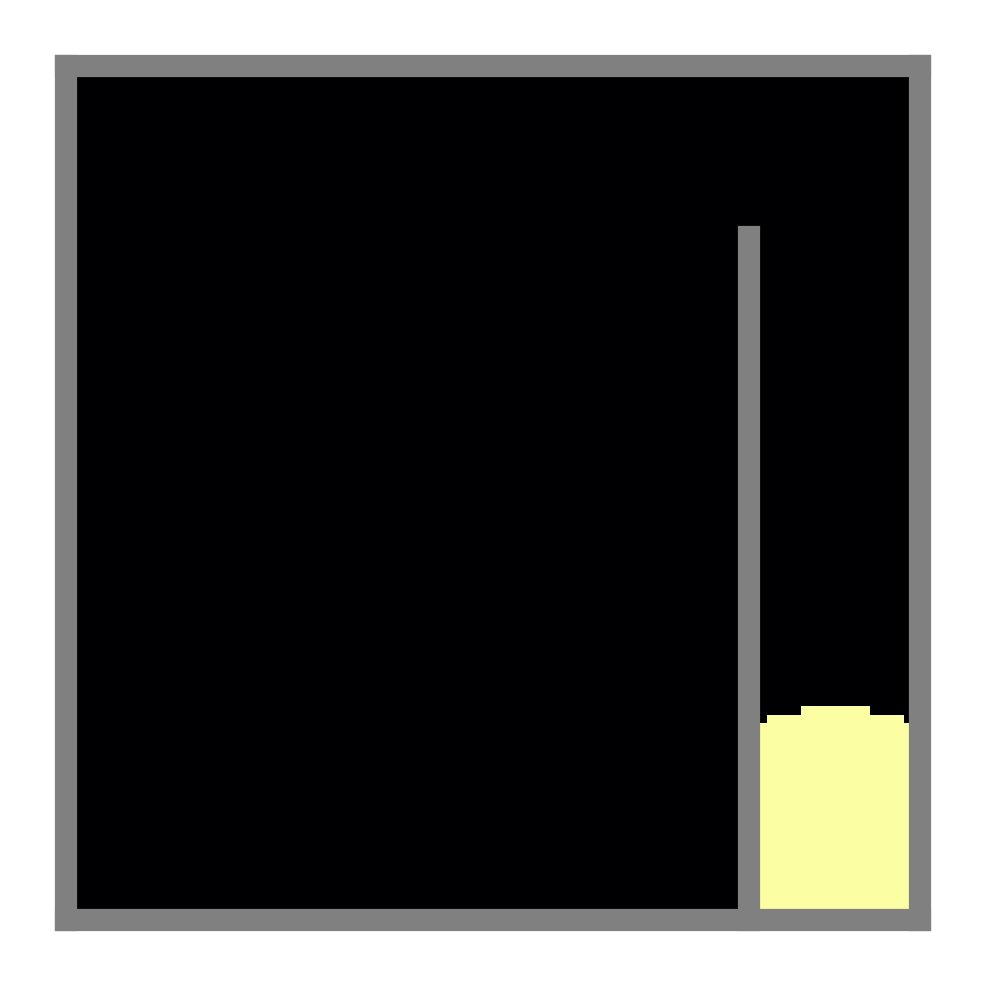

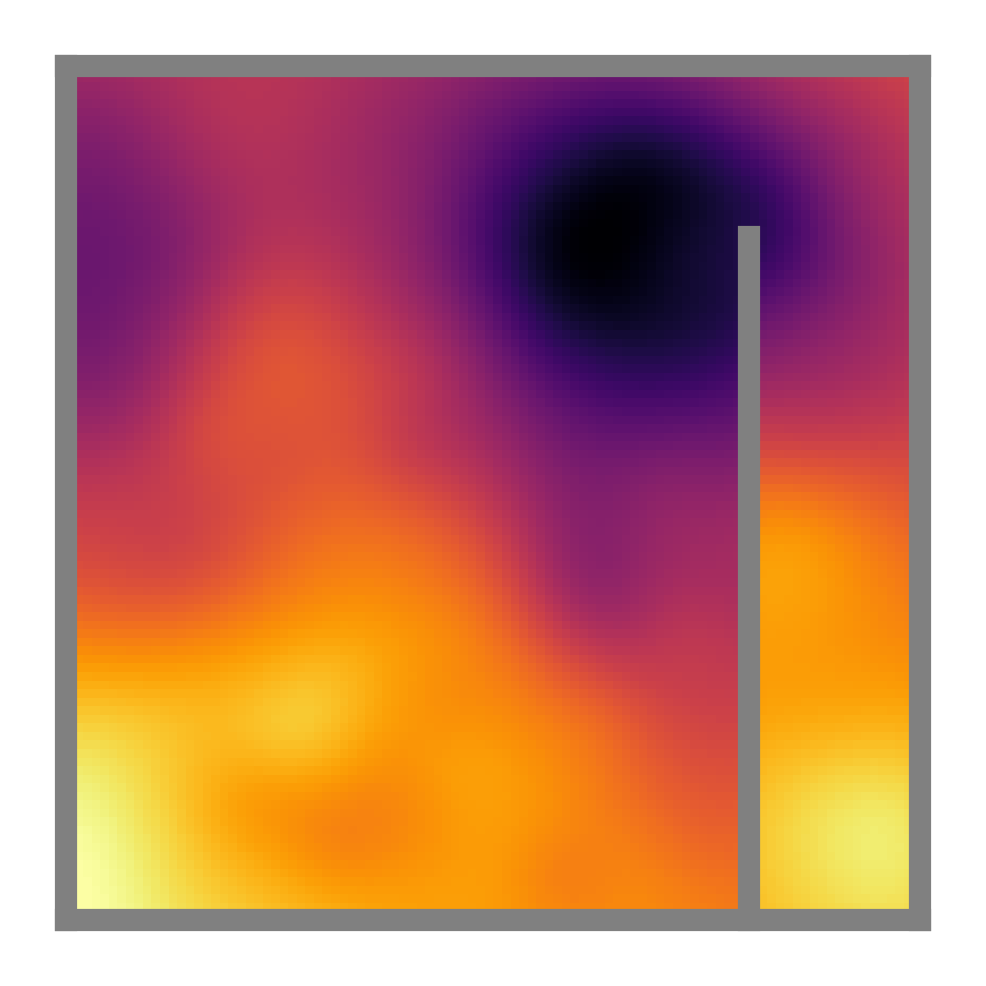

In [39]:
Inputs.plot_rate_map(chosen_neurons='15',shape=(3,5))
Reward.plot_rate_map(chosen_neurons='1')
ValNeur.plot_rate_map(chosen_neurons='1')

We now undergo learning. The policy of the agent is, by default, the smooth random walk inbuilt to `RatInABox`. Let's explore and learn for 5 minutes. After learning we plot the rate map of the `ValueNeuron` and observe high value has been attributed to the area around the reward.  

Start the `Agent` with position on the reward just to help things get going. 

100%|██████████| 6000/6000 [00:07<00:00, 795.14it/s]


(<Figure size 1200x1200 with 1 Axes>, array([<AxesSubplot:>], dtype=object))

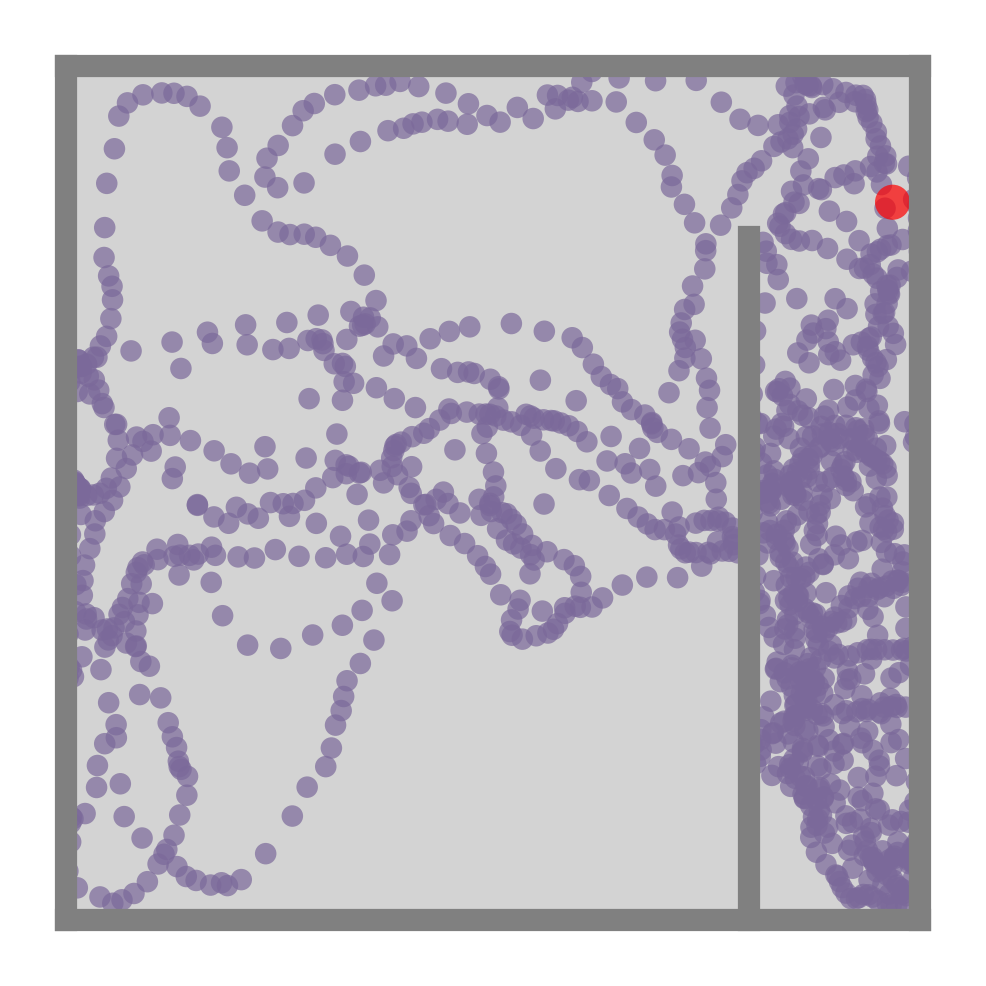

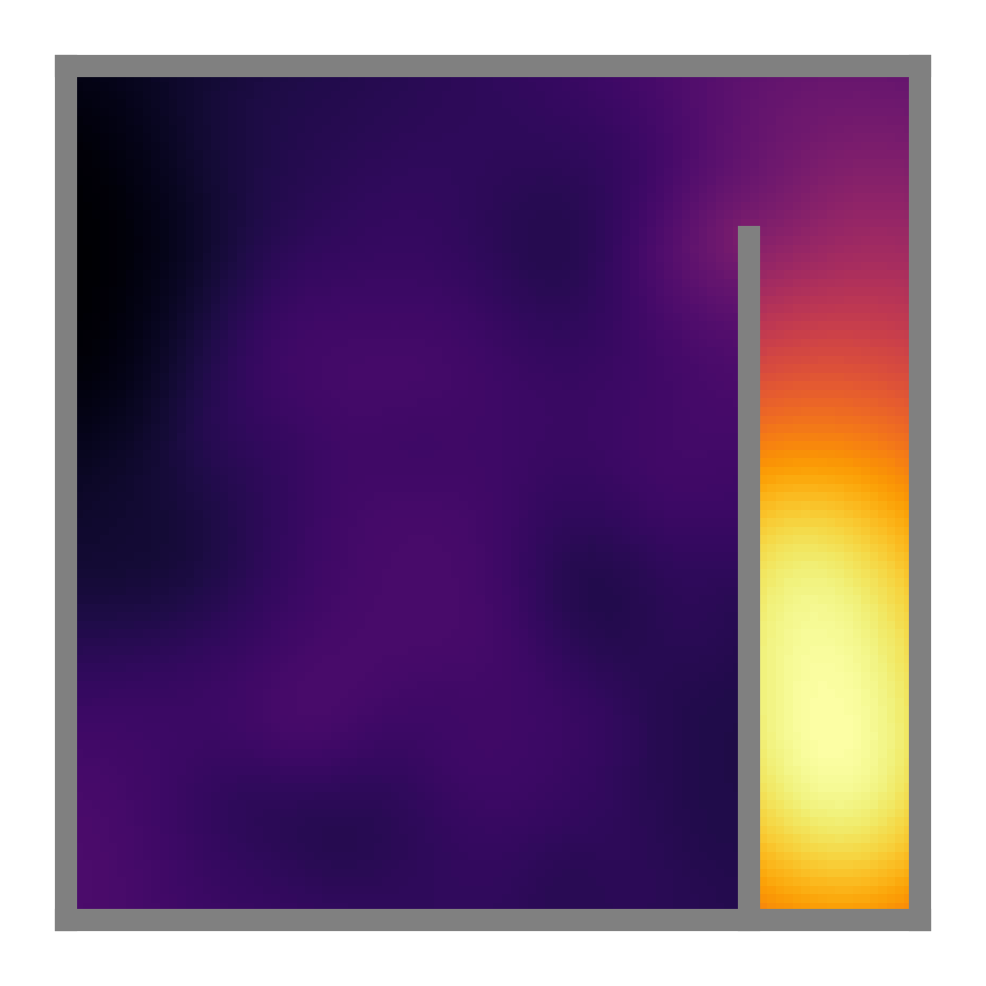

In [40]:
#Explore
Ag.pos = np.array([0.9,0.05])

for i in tqdm(range(int(5*60/Ag.dt))):
    Ag.update()
    Inputs.update()
    Reward.update()
    ValNeur.update_firingrate()
    ValNeur.update_weights()

Ag.plot_trajectory()
ValNeur.plot_rate_map()

## Policy Improvement

Now we have a neuron capable of learning the value function under its current policy ("policy evaluation"). We want to use this to improve the policy ("policy improve") towards an optimal one. To do this will use the inferred value function to set a "drift" velocity which is along the direction of steepest ascent of the value function. This way the `Agent` is encouraged to move towards regions of higher and higher value. The drift velocity will be in the direction of steep ascent of the `ValueNeuron` rate map. This method of value ascent is close to a continuous analog of a "greedy policy optimization" in continuous action space. 

Learing proceeds in episode. Each episode ends when the agent gets close to the reward or times out (60 seconds). Initially the drift velocity is very weak relative to the random policy (controlled using the `drift_to_random_strength_ratio` argument) but this gets stronger as more successful episodes occur and the agent should (hopefully) converge on an approximately optimal policy. An episode ends probabilitically according to the firing rate of the reward neurons (when you are close to the reward it is likely to terminate soon) 

Every 5 episodes we "cache" a copy of the `ValueNeuron` and use this, for the next 5 episodes to provide the steepest ascent direction. We'll store details (start/end time and positions of each episode) in the `Agent` class. 

In [59]:
from time import time 
from copy import copy 

def do_episode(ref_ValNeur,
               ValNeur,
               Ag,
               Inputs,
               Reward,
               train=True):
    Ag.episode_data['start_time'].append(Ag.t)
    Ag.episode_data['start_pos'].append(Ag.pos)

    ValNeur.et = np.zeros_like(ValNeur.et)
    while True: 
        drift_velocity = ref_ValNeur.get_steep_ascent(Ag.pos)
        #you can ignore this (force agent to travel towards reward when v nearby) helps stability. 
        if (Ag.pos[0] > 0.8)  and (Ag.pos[1] < 0.4):
            dir_to_reward = Reward.place_cell_centres[0]-Ag.pos
            drift_velocity = 3*Ag.speed_mean*(dir_to_reward/np.linalg.norm(dir_to_reward))
        
        #move the agent
        Ag.update(drift_velocity=drift_velocity,
                    drift_to_random_strength_ratio = Ag.exploit_explore_ratio)
        #update inputs and train weights 
        Inputs.update()
        Reward.update()
        ValNeur.update_firingrate()
        #train the weights
        if train == True: 
            ValNeur.update_weights()
        #end episode when at some random moment when reward is high OR after timeout 
        if np.random.uniform() < Ag.dt * Reward.firingrate/Reward.episode_end_time:
            Ag.exploit_explore_ratio *= 1.1 #policy gets greedier
            Ag.episode_data['success_or_failure'].append(1)
            break
        if (Ag.t - Ag.episode_data['start_time'][-1]) > 60: #timeout
            Ag.episode_data['success_or_failure'].append(0)
            break
    Ag.episode_data['end_time'].append(Ag.t)
    Ag.episode_data['end_pos'].append(Ag.pos)
    Ag.exploit_explore_ratio = max(0.1,min(1,Ag.exploit_explore_ratio))
    
    return 

Ag.episode_data = {'start_time':[],
                   'end_time':[],
                   'start_pos':[],
                   'end_pos':[],
                   'success_or_failure':[]}
Ag.exploit_explore_ratio = 0.3
Reward.episode_end_time = 3

Now we will do a test over 10 batches of 8 episodes each

In [42]:
for i in range(10):
    #cache copy of the ValueNeuron and use this to dictate policy
    ref_ValNeur = copy(ValNeur)
    ref_ValNeur.max_fr = np.max(ValNeur.get_state(evaluate_at='all'))

    for j in range(8): #batches of episodes 
        Ag.pos = Env.sample_positions(n=1)[0] #put agent in random position
        do_episode(ref_ValNeur,
                   ValNeur,
                   Ag,
                   Inputs,
                   Reward,
                   train=True)

    n_success = sum(Ag.episode_data['success_or_failure'][-8:])
    av_episode_time = np.mean(np.array(Ag.episode_data['end_time'][-8:]) - np.array(Ag.episode_data['start_time'][-8:]))
    print(f"Batch {i+1}/{10}: {8-n_success} timeouts, {n_success} successes, average episode time {av_episode_time:.2f}s")


Batch 1/10: 1 timeouts, 7 successes, average episode time 28.25s
Batch 2/10: 0 timeouts, 8 successes, average episode time 14.12s
Batch 3/10: 0 timeouts, 8 successes, average episode time 8.74s
Batch 4/10: 0 timeouts, 8 successes, average episode time 7.96s
Batch 5/10: 0 timeouts, 8 successes, average episode time 10.92s
Batch 6/10: 0 timeouts, 8 successes, average episode time 10.09s
Batch 7/10: 0 timeouts, 8 successes, average episode time 12.31s
Batch 8/10: 0 timeouts, 8 successes, average episode time 7.72s
Batch 9/10: 0 timeouts, 8 successes, average episode time 7.06s
Batch 10/10: 0 timeouts, 8 successes, average episode time 12.49s


Batch 10/10: 0 timeouts, 8 successes, average episode time 10.62s


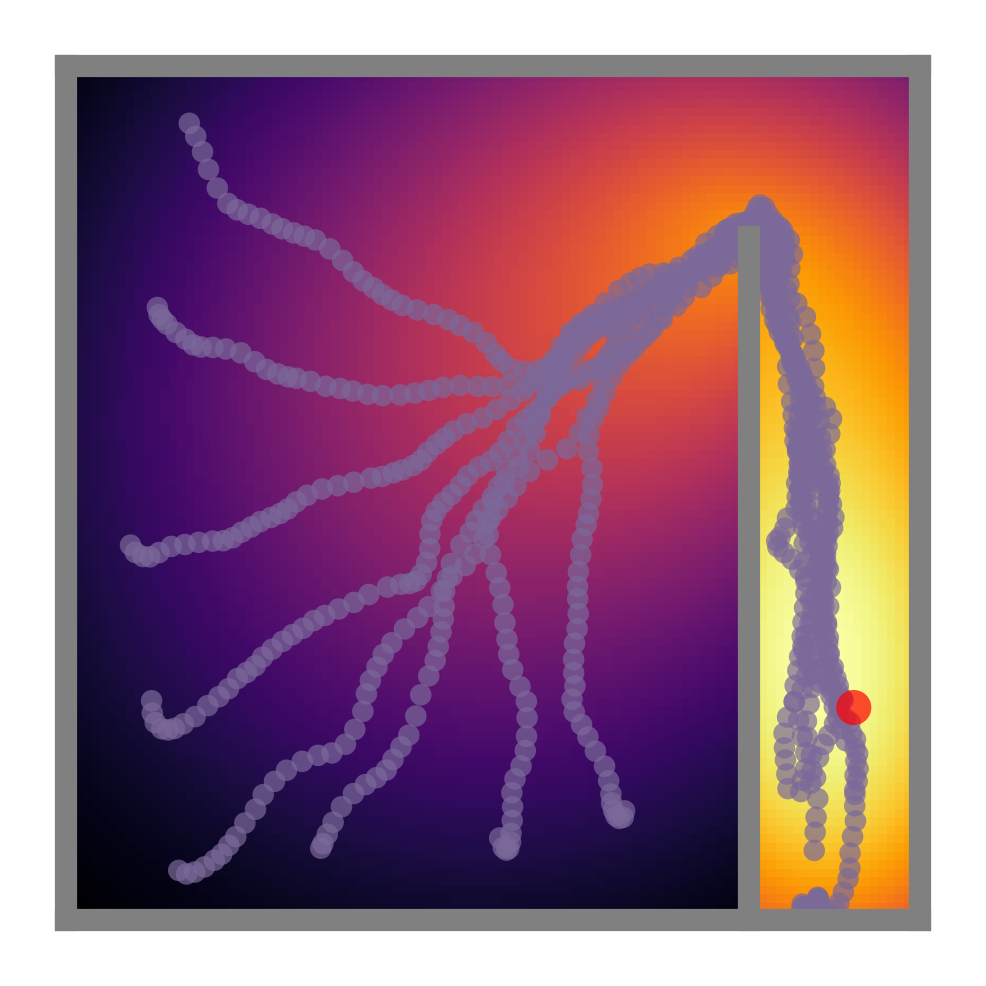

In [44]:
#do a test for plotting, start at some nicely spaced out locations
# Ag.average_measured_speed = 0.1
test_pos = np.array([[0.1,0.9],
                     [0.1,0.7],
                     [0.1,0.5],
                     [0.1,0.3],
                     [0.1,0.1],
                     [0.3,0.1],
                     [0.5,0.1],
                     [0.7,0.1],])
test_pos += np.random.uniform(-0.05,0.05,size=test_pos.shape)
np.random.shuffle(test_pos)
Env.walls[-1,-1,-1]=0.8
Reward.episode_end_time = 1
for j in range(8):
    Ag.pos = test_pos[j]
    do_episode(ref_ValNeur,
               ValNeur,
               Ag,
               Inputs,
               Reward,
               train=False)
n_success = sum(Ag.episode_data['success_or_failure'][-8:])
av_episode_time = np.mean(np.array(Ag.episode_data['end_time'][-8:]) - np.array(Ag.episode_data['start_time'][-8:]))
print(f"Batch {i+1}/{10}: {8-n_success} timeouts, {n_success} successes, average episode time {av_episode_time:.2f}s")

Ag.average_measured_speed = 0.15
fig, ax = ValNeur.plot_rate_map()
fig, ax = Ag.plot_trajectory(fig=fig,ax=ax[0],t_start=Ag.episode_data['start_time'][-8]+Ag.dt)

In [45]:
#OPTIONAL CELL FOR PLOTTING/SAVING ANIMATIONS (i need these for paper/readme but you can ignore) 
import tomplotlib.tomplotlib as tpl
tpl.figureDirectory = "../figures/"
tpl.setColorscheme(colorscheme=2)

start_pos = np.array(Ag.episode_data['start_pos'][-8:])
end_pos = np.array(Ag.episode_data['end_pos'][-8:])
fig, ax = ValNeur.plot_rate_map()
fig, ax = Ag.plot_trajectory(fig=fig,ax=ax[0],t_start = Ag.episode_data['start_time'][-8]+Ag.dt,plot_agent=False)
ax.scatter(start_pos[:,0],start_pos[:,1],s=20,c='C2',zorder=11,alpha=0.8,linewidths=0)
ax.scatter(end_pos[-8:,0],end_pos[-8:,1],s=20,c='r',zorder=11,alpha=0.8,linewidths=0)
tpl.saveFigure(fig,"trained_rl_agent")

# anim = Ag.animate_trajectory(t_start = Ag.episode_data['start_time'][-8]+Ag.dt, t_end=Ag.history['t'][-1],speed_up=3)
# anim.save("../figures/animations/rl_agent.mp4",dpi=250)

## A Freebie from doing RL in continuous space and time

One of the key premises leading to the development of `RatInABox` is that, oftentimes, studying systems in their full form -- i.e. using motion models which are continuous in time and state encodings which are continuous in space and interact adaptively with the environment -- can lead to results which are quantitatively different from gridworld models. These might explain aspects of behaviour inaccessible using discretised models. What might these be? 

As an example, suppose a shortcut was made avaiable near the bottom of the wall. In this case the place cells near the reward location might be expected to 'bleed' out. This occurs naturally in `RatInABox`: since `PlaceCell` firing rates are calculated on-the-fly (not cached) any change to the environment immediately effects the place cells. Sincethe `ValueNeuron` receptive field is just a linear sum of these place cells as the place cells bleed out through the hole in the wall the inferred value of this area increases. The policy (gradient ascent of the value function)may then follow this and automatically find a `shortcut' to the reward with zero extra training. Let's find out: 

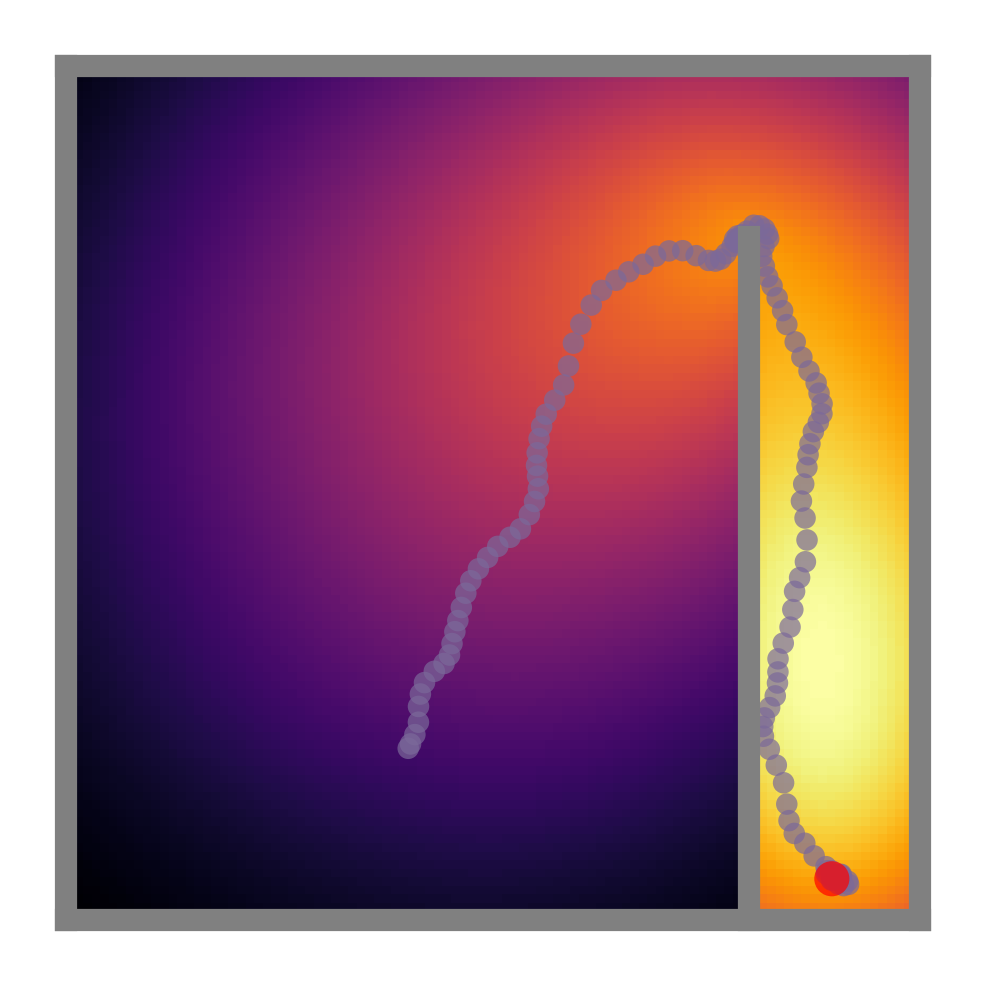

In [60]:
#first test without an available shortcut (same as above) 
Env.walls[-1] = np.array([[0.8,0.0],[0.8,0.8]])
Reward.episode_end_time = 3
Ag.pos = np.array([0.4,0.2])
do_episode(ref_ValNeur,
            ValNeur,
            Ag,
            Inputs,
            Reward,
            train=False)

Ag.average_measured_speed = 0.15
fig, ax = ValNeur.plot_rate_map()
fig, ax = Ag.plot_trajectory(fig=fig,ax=ax[0],t_start=Ag.episode_data['start_time'][-1]+Ag.dt)

In [61]:
tpl.saveFigure(fig,"rl_noshortcut")
anim = Ag.animate_trajectory(t_start = Ag.episode_data['start_time'][-1]+Ag.dt, t_end=Ag.history['t'][-1],speed_up=1)
anim.save("../figures/animations/rl_agent_noshortcut.mp4",dpi=250)

Make a shortcut availabe by manually altering the wall structure of the environment. Everythign else is taken care of by the software (i.e. inoput `PlaceCell` firing fields, and the `ValueNeuron` firing will all respect this new change in teh environment). 

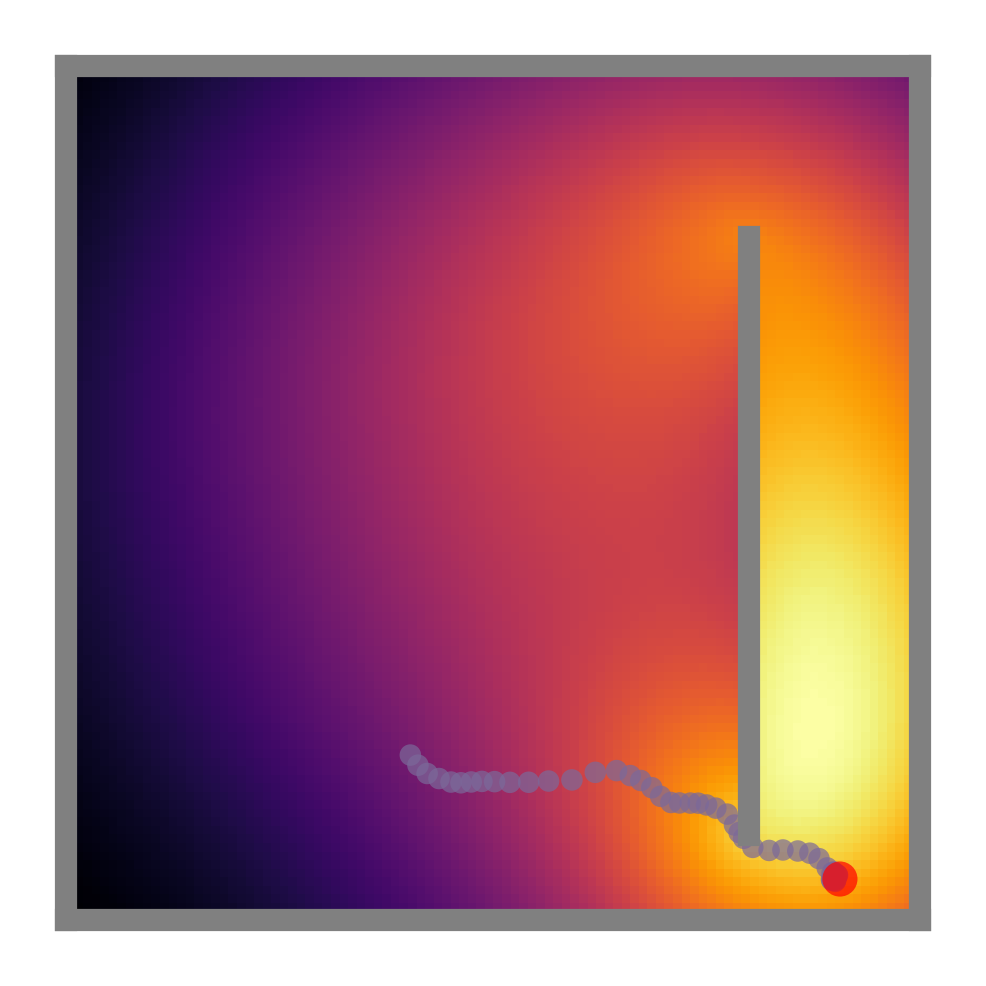

In [70]:
#now add in a shortcut by altering the wall structure of the environent 
Env.walls[-1] = np.array([[0.8,0.1],[0.8,0.8]])
# Reward.episode_end_time = 3
Ag.pos = np.array([0.4,0.2])
do_episode(ref_ValNeur,
            ValNeur,
            Ag,
            Inputs,
            Reward,
            train=False)
Ag.average_measured_speed = 0.15
fig, ax = ValNeur.plot_rate_map()
fig, ax = Ag.plot_trajectory(fig=fig,ax=ax[0],t_start=Ag.episode_data['start_time'][-1]+Ag.dt)

In [71]:
tpl.saveFigure(fig,"rl_shortcut")
anim = Ag.animate_trajectory(t_start = Ag.episode_data['start_time'][-1]+Ag.dt, t_end=Ag.history['t'][-1],speed_up=1)
anim.save("../figures/animations/rl_agent_shortcut.mp4",dpi=250)

### Disclaimer: 
Please note this script is intended as a tutorial/demonstraion of how `RatInABox` could be used for a reinforcement learning project in continuous time and space and **not**, in any way, as a scientific result regarding the role of hippocampus' role in navigational reinforcement learning. 